# Importing required libraries

In [1]:
import torch
import numpy as np
import os
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from torch.utils.data import Dataset
from natsort import natsorted
from PIL import Image
from pathlib import Path

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CNN Model

In [3]:
class my_CNN(nn.Module):
    def __init__(self, csize = [126, 108, 123, 102, 116], ksize = [2, 2, 2, 2], 
                 numclasses = 4, inputdim = 3, inputsize = 128):
        super(my_CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(inputdim, csize[0], ksize[0])
        self.conv2 = nn.Conv2d(csize[0], csize[1], ksize[1])
        self.conv3 = nn.Conv2d(csize[1], csize[2], ksize[2])
        self.conv4 = nn.Conv2d(csize[2], csize[3], ksize[3])
        self.pool = nn.MaxPool2d(2, 2)

        self.temp1 = int((inputsize - ksize[0] + 1)/2)
        self.temp2 = int((self.temp1 - ksize[1] + 1)/2)
        self.temp3 = int((self.temp2 - ksize[2] + 1)/2)
        self.temp4 = int((self.temp3 - ksize[3] + 1)/2)
        self.fcin = csize[3]*pow(self.temp4,2)
        self.fc1 = nn.Linear(self.fcin, csize[4])
        self.fc2 = nn.Linear(csize[4], numclasses)

    def forward(self, img):
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, self.fcin)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
# Loading saved state of trained model
model = my_CNN()
saved_state = '/content/drive/MyDrive/APS360_project/saved_states/AUGmodel/AUGmodel_CNN_epoch0_valacc0.696'

# CNN Voting


In [5]:
# Creating the dataset

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform, img_label):
        self.main_dir = main_dir
        self.transform = transform
        filelist = []

        for root, dirs, files in os.walk(main_dir):
          for file in files:
            # append the file name to the listto
            filelist.append(os.path.join(root,file))
        
        all_imgs = filelist
        self.total_imgs = natsorted(all_imgs)
        self.img_labels = [img_label for i in range(len(self.total_imgs))]

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        label = self.img_labels[idx]
        return tensor_image, label

dataset = []
genres = ['Electronic', 'Folk', 'Hip-Hop', 'Rock']
path = '/content/drive/MyDrive/APS360_project/spectrogram_test'
i = 0

transform = transforms.Compose([transforms.Resize((128,128)), 
                                  transforms.ToTensor()])

for genre in genres:
  dataset.append(CustomDataSet(path + "/" + genre, transform, i))
  print(path + "/" + genre)
  print(len(dataset[i]))

  i += 1

/content/drive/MyDrive/APS360_project/spectrogram_test/Electronic
1110
/content/drive/MyDrive/APS360_project/spectrogram_test/Folk
1080
/content/drive/MyDrive/APS360_project/spectrogram_test/Hip-Hop
1110
/content/drive/MyDrive/APS360_project/spectrogram_test/Rock
1110


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


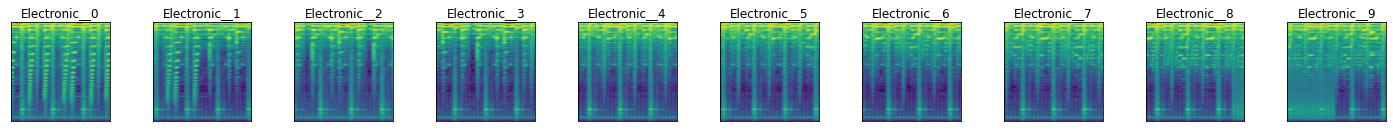

In [6]:
# Creating the dataloaders

dataloader = []

# dataloader for each dataset
for i in range(len(genres)):
  dataloader_obj = torch.utils.data.DataLoader(dataset[i], batch_size=10, 
                                                 num_workers=8)
  dataloader.append(dataloader_obj)

# display a sample
dataiter = iter(dataloader[0])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(genres[labels[idx]] + "_" + str(idx)[:-1]+ "_" + str(idx)[-1])

In [7]:
import statistics
from statistics import mode

def save_statistics(label, song_pred, slice_pred, df):
  # label is list of tensor of 1 number
  # song_pred is list of tensor of 1 number
  # slice_pred is tensor of array size 10
  # df is pd dataframe to append

  return df.append({"label": label[0].detach().item(), 
                    "song_pred": song_pred[0].detach().item(), 
                    "pred_0": np.count_nonzero(slice_pred.detach().numpy() == 0),
                    "pred_1": np.count_nonzero(slice_pred.detach().numpy() == 1),
                    "pred_2": np.count_nonzero(slice_pred.detach().numpy() == 2),
                    "pred_3": np.count_nonzero(slice_pred.detach().numpy() == 3),},
                   ignore_index=True)

def evaluate_voting(model, data_loader, df):
    correct = 0
    total = 0
    
    print("Number correct:")

    for imgs, labels in data_loader:        
        # if torch.cuda.is_available():
        #   imgs = imgs.cuda()
        #   labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1].detach()

        # take the majority vote as the final one
        final_pred = []
        final_labels = []

        for start_idx in range(0,len(pred),10):
          slice_pred = torch.cat(pred[start_idx:start_idx+10].unbind())
          song_pred = torch.mode(slice_pred,0)[0]
          final_pred.append(song_pred)
          final_labels.append(labels[start_idx])

          # print(f"\tPredictions for song: {slice_pred}")
          # print(f"\tMode: {song_pred}")
          # print(f"\tPredicted genre for song: {genres[song_pred]}")
          # print(f"\tActual genre for song: {genres[labels[start_idx]]}")
        # check correctness
        correct += (final_pred == final_labels)
        total += imgs.shape[0]//10

        print(f"\t{correct} of {total} ({correct/total*100:.3f}%)")
        print(f"\t\tPredictions for slices: {slice_pred}")
        print(f"\t\tFinal predictions: {final_pred}")
        print(f"\t\tFinal labels: \t{final_labels}")
        df = save_statistics(final_labels, final_pred, slice_pred, df)

    return correct / total, df

In [15]:
# === VOTING MODEL ===
model = my_CNN()
saved_state = '/content/drive/MyDrive/APS360_project/saved_states/AUGmodel/AUGmodel_best'
model.load_state_dict(torch.load(saved_state, map_location=torch.device('cpu')))
test_acc = []
df = pd.DataFrame(columns=["label", "song_pred", "pred_0", "pred_1", "pred_2", "pred_3"])

for genre_set in np.arange(4):
  acc, df = evaluate_voting(model, dataloader[genre_set], df)
  test_acc.append(acc)
  print(f"Accuracy for {genres[genre_set]}: {test_acc[genre_set]}")

Number correct:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


	1 of 1 (100.000%)
		Predictions for slices: tensor([0, 1, 2, 1, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(0)]
	2 of 2 (100.000%)
		Predictions for slices: tensor([2, 0, 2, 0, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(0)]
	3 of 3 (100.000%)
		Predictions for slices: tensor([0, 0, 2, 2, 0, 2, 0, 2, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(0)]
	4 of 4 (100.000%)
		Predictions for slices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(0)]
	4 of 5 (80.000%)
		Predictions for slices: tensor([2, 0, 2, 2, 2, 2, 2, 2, 2, 1])
		Final predictions: [tensor(2)]
		Final labels: 	[tensor(0)]
	5 of 6 (83.333%)
		Predictions for slices: tensor([2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
		Final predictions: [tensor(0)]
		Final labels: 	[tensor(0)]
	5 of 7 (71.429%)
		Predictions for slices: tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2])
		Final predictions: [tensor(2)]
		Final la

In [10]:
genre_accuracy = pd.DataFrame(data={'category': genres, 'voting_accuracy': test_acc})
genre_accuracy

,category,voting_accuracy
0,Electronic,0.630631
1,Folk,0.907407
2,Hip-Hop,0.657658
3,Rock,0.720721


In [12]:
pd.DataFrame(data={"Overall": 'overall', 'Voting Accuracy': genre_accuracy.mean().voting_accuracy}, index=[0]) 


,Overall,Voting Accuracy
0,overall,0.729104
